### The following notebook accomplishes the following things:
1. Extracts the results from the observations file 
2. Creates the input file for initial conditions based on the spinup observations

- The following files are based on the scenario I as described in - D:\Seafile_folders\Seafile\My Library\Hannover_PhD\Work\ATS\RKModel\RKModel_info_simulation_strategy.xlsx\Spin_up_strategy


This folder contains spinup simulation results. There are two kinds of spinups - Static and dynamic spinup.
The static spinup case establishes a water column and freezes the column from the bottom. It is the initial condition for dynamic spinup. 
The dynamic spinup case applies cyclic average forcing data on the top for 10 years and then use it as the initial condition for calibration.



**The following notebook is an attempt to write the code concisely to extract all the datasets**

Spin-up process: The following text is copied from the ats demo file - https://github.com/amanzi/ats-demos/blob/master/06_arctic_hydrology/arctic_hydrology.ipynb

### spinup: Freeze steady-state to generate ice column
Transient simulations in areas of continuous permafrost are initialized in the winter to make spinup simpler. Therefore we start from a fully frozen domain (instead of the partially frozen domain that would be required for starting any other time of year).

Transient simulations in areas of seasonally frozen ground, however, would typically be started in the summer for the same reason. Transient simulations in areas of discontinuous permafrost or areas with taliks are challenging, and typically need more extensive spinup processes.

For continuous permafrost, to establish this fully-frozen domain, we freeze the hydrostatic water column from below until the solution reaches steady-state again. This "pseudo-transient" approach is easier for solvers than solving the steady-state problem. This is done in the subsurface only, solving coupled Richards and energy equations.

Here we look at a study from the Barrow Environmental Observatory in Utqiagvik, AK. The bottom boundary temperature is set at -9 F, which is, according to deep borehole data, a reasonable temperature for deep permafrost in Barrow. As the column freezes, water expands to form ice, pushing the water above it up. This results in a careful balance -- we want to set the bottom pressure in freezeup such that, when frozen, the ice table is near the surface, but not above it (which would break the problem here because a no flux condition is put on that top surface). The calculation of such a pressure is difficult, as it depends upon soil properties, freezing rates, and other dynamic things, so a test-and-check approach is taken.

First, an initial water table location is specified by the hydrostatic initial condition. After the simulation, if the resulting ice table is too high, the pressure in the top cell will blow up, and the process is repeated with a lower initial water table. If the resulting ice table is too low, the entire active layer will happen in an unsaturated zone, and the soil will never saturate, so the initial water table must be adjusted upwards. Typically, for coastal polygonal permafrost, the soil is quite wet, so we work to get the ice table as close to the surface as possible. More thought might be required for a drier condition, but remember that too wet is rarely an issue (things can drain over a few dynamic years fairly quickly as long as they thaw, but filling up from too dry takes a much longer time). Bisection on the initial water table can be used to quickly find a value that hits an appropriate ice table level.

NOTE: From here on, transient problems are plotted such that early times have low intensity colors, and late times are high intensity colors. The initial condition is therefore the lightest line, while the darkest line is the final, steady-state solution.

NOTE: This run takes some time (especially if the code is built in debug mode), up to ~10 minutes.

Important notes from https://github.com/amanzi/ats-demos/blob/master/06_arctic_hydrology/freezeup.xml
- Time period: 1000 years
- Bottom B.C: 0 --> -9°C (Do we assume the same?)
- Case file: Case 1 (Which contains only subsurface processes)
- Hydrostatic head: -1 m
- Initial temperature: 270.15 (or 265 K?)


### Dynamic fully coupled run with annual cyclic steady state forcing


Next, the permafrost_column run demonstrates the typical transient column run. This includes all thermal hydrology processes:

- subsurface flow (modified Richards)
- subsurface energy
- surface flow
- surface energy
- surface energy balance

This model is forced with meteorological data. Here we will use DayMet, which provides daily historical QA'd datasets for meteorological data on a 1km US grid, and covers Alaska. These datasets were created using DayMet for Barrow:

python $ATS_SRC_DIR/tools/utils/daymet_to_ats.py 71.2718 -156.6202

and then smoothed to generate spinup data via:

python $ATS_SRC_DIR/tools/utils/smooth_met.py -n 10 daymet_raw_71p2718_-156p6202.h5

This is called a spinup run because it sets a typical cyclic steady state, and puts the permafrost a reasonable state to then do dynamic, "real data" runs with met data from real years instead of averaged, typical years. These dynamic runs use the same transient processes, just different forcing data.

Important notes from https://github.com/amanzi/ats-demos/blob/master/06_arctic_hydrology/freezeup.xml
- Time period: 10 years
- Bottom B.C: -9°C (Do we assume the same? or nothing just as before)
- Case file: Case 3 (Which contains surface and subsurface processes)
- Hydrostatic head: initialized from static run
- Initial temperature: initialized from static run
- Initial snow depth: We'll assume a very small value
- Forcing function: Met station data (smoothed?)

In [52]:
%matplotlib inline
import sys,os
import ats_xdmf
import plot_column_data
import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt
import h5py
import pandas as pd
import matplotlib.gridspec as gridspec

### Observation data

In [53]:
df_obs_AWS = pd.read_csv('../1_data_prep/Final_OutputData_4yrs/Calib_outputdata_2016_2018.csv',sep='\t')
df_obs_AWS.head()

,TIMESTAMP,Soil moisture at - 0.04 m (%),Soil moisture at - 0.1 m (%),Soil moisture at - 0.2 m (%),Soil moisture at - 0.4 m (%),Soil moisture at - 0.8 m (%),Soil moisture at - 1.2 m (%),Soil moisture at - 1.6 m (%),Soil temperature at - 0.00 m (°C),Soil temperature at - 0.04 m (°C),Soil temperature at - 0.1 m (°C),Soil temperature at - 0.2 m (°C),Soil temperature at - 0.4 m (°C),Soil temperature at - 0.8 m (°C),Soil temperature at - 1.2 m (°C),Soil temperature at - 1.6 m (°C)
0,2016-01-01,7.897694,7.523868,8.694236,9.016111,5.368792,4.093549,6.058042,-13.103958,-12.507847,-11.848819,-11.295486,-9.824722,-7.814958,-4.874889,-3.447965
1,2016-01-02,7.991826,7.594250,8.745417,9.012639,5.350889,4.060958,6.008417,-12.255417,-11.861597,-11.342569,-10.947708,-9.781389,-7.936854,-5.063889,-3.639549
2,2016-01-03,7.992500,7.606875,8.766806,9.033472,5.342833,4.033590,5.962187,-12.737500,-11.824514,-11.200694,-10.765278,-9.618403,-7.946111,-5.228028,-3.817500
3,2016-01-04,7.960069,7.581465,8.749236,9.025833,5.336757,4.012583,5.923819,-13.006597,-11.997847,-11.365486,-10.867778,-9.648889,-7.977951,-5.358771,-3.977958
4,2016-01-05,7.913792,7.539000,8.703056,8.995694,5.324597,3.993715,5.892174,-13.525278,-12.371597,-11.691181,-11.171181,-9.829653,-8.078194,-5.476889,-4.119438


In [54]:
### Temperature from degree celcius to Kelvin

depths = [0.04, 0.1, 0.2, 0.4, 0.8, 1.2, 1.6]

for i, depth in enumerate(depths):
    df_obs_AWS[f'point -{depth} temperature [K]'] = df_obs_AWS[f'Soil temperature at - {depth} m (°C)'] + 273.15
    
df_obs_AWS.head()

,TIMESTAMP,Soil moisture at - 0.04 m (%),Soil moisture at - 0.1 m (%),Soil moisture at - 0.2 m (%),Soil moisture at - 0.4 m (%),Soil moisture at - 0.8 m (%),Soil moisture at - 1.2 m (%),Soil moisture at - 1.6 m (%),Soil temperature at - 0.00 m (°C),Soil temperature at - 0.04 m (°C),...,Soil temperature at - 0.8 m (°C),Soil temperature at - 1.2 m (°C),Soil temperature at - 1.6 m (°C),point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K]
0,2016-01-01,7.897694,7.523868,8.694236,9.016111,5.368792,4.093549,6.058042,-13.103958,-12.507847,...,-7.814958,-4.874889,-3.447965,260.642153,261.301181,261.854514,263.325278,265.335042,268.275111,269.702035
1,2016-01-02,7.991826,7.594250,8.745417,9.012639,5.350889,4.060958,6.008417,-12.255417,-11.861597,...,-7.936854,-5.063889,-3.639549,261.288403,261.807431,262.202292,263.368611,265.213146,268.086111,269.510451
2,2016-01-03,7.992500,7.606875,8.766806,9.033472,5.342833,4.033590,5.962187,-12.737500,-11.824514,...,-7.946111,-5.228028,-3.817500,261.325486,261.949306,262.384722,263.531597,265.203889,267.921972,269.332500
3,2016-01-04,7.960069,7.581465,8.749236,9.025833,5.336757,4.012583,5.923819,-13.006597,-11.997847,...,-7.977951,-5.358771,-3.977958,261.152153,261.784514,262.282222,263.501111,265.172049,267.791229,269.172042
4,2016-01-05,7.913792,7.539000,8.703056,8.995694,5.324597,3.993715,5.892174,-13.525278,-12.371597,...,-8.078194,-5.476889,-4.119438,260.778403,261.458819,261.978819,263.320347,265.071806,267.673111,269.030562


In [55]:
####  Converting Soil moisture content to saturation of liquid

depths = [0.04, 0.1, 0.2, 0.4, 0.8, 1.2, 1.6]

depth_peat = 0.3
poro_peat = 0.501199
poro_mineral = 0.407367

for i, depth in enumerate(depths):
    if depth < depth_peat:
        df_obs_AWS[f'point -{depth} saturation liquid'] = df_obs_AWS[f'Soil moisture at - {depth} m (%)']/(poro_peat*100)
    else:
        df_obs_AWS[f'point -{depth} saturation liquid'] = df_obs_AWS[f'Soil moisture at - {depth} m (%)']/(poro_mineral*100)

### Static spinup - I.C for all cases!

#### 1. Extracts the results from the observations file 

In [56]:
# Reading the csv file 
df_observation = pd.read_csv('Case1_static_spinup.demo/observations.dat', skiprows=178, sep=' ')
df_observation['time [days]'] = df_observation['time [s]']/86400
df_observation.index = df_observation['time [days]']

df_observation.head()

,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -5.0 temperature [K],point -10.0 temperature [K],...,point -0.04 saturation ice,point -0.1 saturation ice,point -0.2 saturation ice,point -0.4 saturation ice,point -0.8 saturation ice,point -1.2 saturation ice,point -1.6 saturation ice,point -5.0 saturation ice,point -10.0 saturation ice,time [days]
time [days],,,,,,,,,,,,,,,,,,,,,
0.0,0.0,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,...,0.523195,0.536892,0.552182,0.299482,0.571921,0.826493,0.826493,0.826493,0.826493,0.0
1.0,86400.0,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,...,0.523195,0.536892,0.552182,0.299482,0.571921,0.826493,0.826493,0.826493,0.826493,1.0
2.0,172800.0,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,...,0.523195,0.536892,0.552182,0.299482,0.571921,0.826493,0.826493,0.826493,0.826493,2.0
3.0,259200.0,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,...,0.523195,0.536892,0.552182,0.299482,0.571921,0.826493,0.826493,0.826493,0.826493,3.0
4.0,345600.0,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,268.45,...,0.523195,0.536892,0.552182,0.299482,0.571921,0.826493,0.826493,0.826493,0.826493,4.0


In [57]:
len(df_observation)

36526

In [58]:
### Extracting the final results from spinup (Check)

### Reading the file once more to check
### Extracting the data from the example 'column_data.h5'.  
with h5py.File(f'Case1_static_spinup.demo/checkpoint_final.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    air_temp = np.array(hdf.get('temperature.cell.0'))
    print(len(np.array(hdf.get('temperature.cell.0'))))
    #print(air_temp)

    #temperature_column = np.array(hdf.get('temperature.cell.0/1600'))

List of datasets in this file: 
 
 ['advected_energy_flux.face.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'diffusive_energy_flux.face.0', 'dupwind_enthalpy_times_relative_permeability|dpressure.face.0', 'dupwind_enthalpy_times_relative_permeability|dtemperature.face.0', 'dupwind_relative_permeability|dpressure.face.0', 'dupwind_relative_permeability|dtemperature.face.0', 'dupwind_thermal_conductivity|dpressure.face.0', 'dwater_content|dtemperature.cell.0', 'mass_flux.face.0', 'mass_flux_direction.face.0', 'pressure.cell.0', 'pressure.face.0', 'temperature.cell.0', 'temperature.face.0', 'upwind_enthalpy_times_relative_permeability.face.0', 'upwind_relative_permeability.face.0', 'upwind_thermal_conductivity.face.0']


400


#### Plotting the values 
##### 1. Subsurface temperature

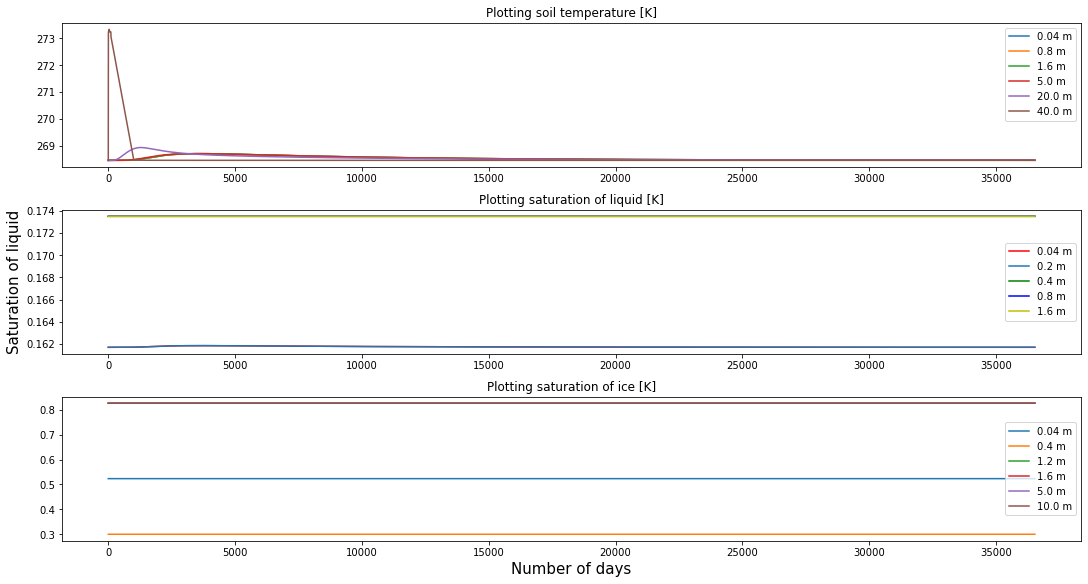

In [59]:
### Plotting the final results (mesured vs simulated) along with the parameters:
### Plotting the temperature for different alpha values at depth 0.01 m
fig2 = plt.figure(figsize=(15,8), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[1,1,1], figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])

# Plotting temperature
f2_ax1.set_title('Plotting soil temperature [K]')
#plt.plot(df_observation['point -0.01 temperature [K]'][:1000],label='0.01 m')
f2_ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
#f2_ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#f2_ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
f2_ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#f2_ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
f2_ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
f2_ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
#f2_ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
f2_ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
f2_ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')
f2_ax1.legend()

# Plotting saturation of liquid
f2_ax2.set_title('Plotting saturation of liquid [K]')
#plt.plot(df_observation['point -0.01 temperature [K]'][:1000],label='0.01 m')
f2_ax2.plot(df_observation['point -0.04 saturation liquid'],'r',label='0.04 m')
f2_ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
f2_ax2.plot(df_observation['point -0.4 saturation liquid'],'g',label='0.4 m')
f2_ax2.plot(df_observation['point -0.8 saturation liquid'],'b',label='0.8 m')
f2_ax2.plot(df_observation['point -1.6 saturation liquid'],'y',label='1.6 m')
#f2_ax2.plot(df_obs_AWS['point -0.04 saturation liquid'],'r--',label='s - 0.04 m')
#f2_ax2.plot(df_obs_AWS['point -0.4 saturation liquid'],'g--',label='s - 0.4 m')
#f2_ax2.plot(df_obs_AWS['point -0.8 saturation liquid'],'b--',label='s - 0.8 m')
#f2_ax2.plot(df_obs_AWS['point -1.6 saturation liquid'],'y--',label='s - 1.6 m')
f2_ax2.legend()
f2_ax2.set_ylabel('Saturation of liquid',fontsize=15)

# Plotting saturation of ice
f2_ax3.set_title('Plotting saturation of ice [K]')
#plt.plot(df_observation['point -0.01 temperature [K]'][:1000],label='0.01 m')
f2_ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
#f2_ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
f2_ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
#f2_ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
f2_ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
f2_ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
f2_ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
f2_ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')
f2_ax3.set_xlabel('Number of days',fontsize=15)
f2_ax3.legend()


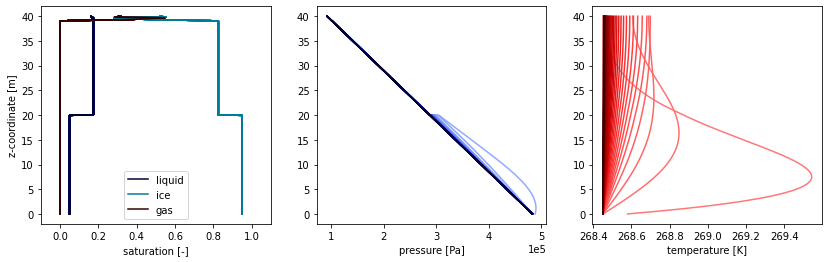

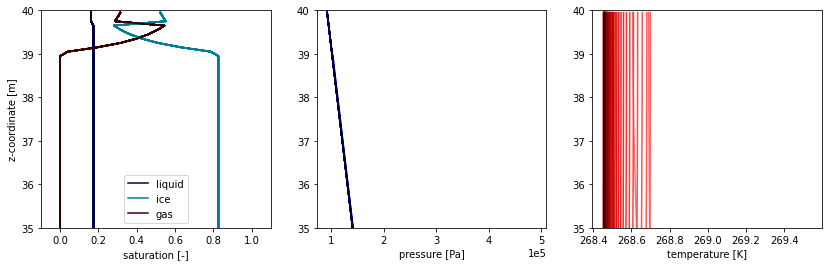

In [60]:
# plot the solution
directory = "Case1_static_spinup.demo"

#
# plot the solution
#
def plot(dirname, axs):
    """A generic plotting function that plots saturation as a function of depth."""

    plot_column_data.plot_subsurface(vis, ['pressure',], axs[0], cmap='jet')
    axs[0].set_xlabel('pressure [Pa]')
    ax.set_ylabel('z [m]')
    
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[1], None, cmap='jet')
    axs[0].set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

def plot(directory, axs, style):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times
    
    ice = colors.cm_mapper(-10000, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10000, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10000, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = vis.centroids[:,2]
    for i,t in enumerate(times):
        label = False
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
        axs[2].plot(dati[5,i,:],z, style, color=gas(t))
        axs[1].plot(dati[1,i,:],z, style, color=water(t))
        axs[0].plot(dati[2,i,:],z, style, color=water(t))
        axs[0].plot(dati[3,i,:],z, style, color=ice(t))
        axs[0].plot(dati[4,i,:],z, style, color=gas(t))

def decorate(axs):
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[1].set_xlabel('pressure [Pa]')
    axs[2].set_xlabel('temperature [K]')
    axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs[0].set_xlim([-.1,1.1])
    axs[0].legend()


# full column
fig, axs = plt.subplots(1,3, figsize=(14,4))
plot(directory, axs, '-')
decorate(axs)

# and a zoomed version
fig, axs = plt.subplots(1,3, figsize=(14,4))
plot(directory, axs, '-')
decorate(axs)
axs[0].set_ylim([35,40])
axs[1].set_ylim([35,40])
axs[2].set_ylim([35,40])


plt.show()

### Dynamic spinup (Scenario II) - Case 1 

In [61]:
# Reading the csv file 
#/home/rk/ats_rk/testing/ats-demos/rk_model/Spinup_final_10032022/Case2
df_observation = pd.read_csv('Case1_dynamic_spinup.demo/observations.dat', skiprows=304, sep=' ')
df_observation['time [days]'] = df_observation['time [s]']/86400
df_observation.index = df_observation['time [days]']

df_observation.head()

,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -5.0 temperature [K],point -10.0 temperature [K],...,point -0.4 saturation gas,point -0.8 saturation gas,point -1.2 saturation gas,point -1.6 saturation gas,point -5.0 saturation gas,point -10.0 saturation gas,point -20.0 saturation gas,point -30.0 saturation gas,point -40.0 saturation gas,time [days]
time [days],,,,,,,,,,,,,,,,,,,,,
0.0,0.0,268.453858,268.453858,268.453858,268.453857,268.453856,268.453853,268.453850,268.453783,268.453552,...,0.258923,0.138283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,86400.0,260.622575,263.457540,265.642131,267.034519,268.211973,268.424822,268.449519,268.453782,268.453551,...,0.258951,0.138291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2.0,172800.0,259.758905,262.173317,264.274900,265.842241,267.686627,268.281554,268.409741,268.453781,268.453551,...,0.258980,0.138310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3.0,259200.0,259.436834,261.532980,263.456210,264.996804,267.144782,268.066729,268.331114,268.453779,268.453550,...,0.259001,0.138332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4.0,345600.0,260.056561,261.627718,263.186741,264.528498,266.680570,267.818230,268.218776,268.453770,268.453550,...,0.259013,0.138352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [62]:
len(df_observation)

3651

#### Plotting the values 
##### 1. Subsurface temperature

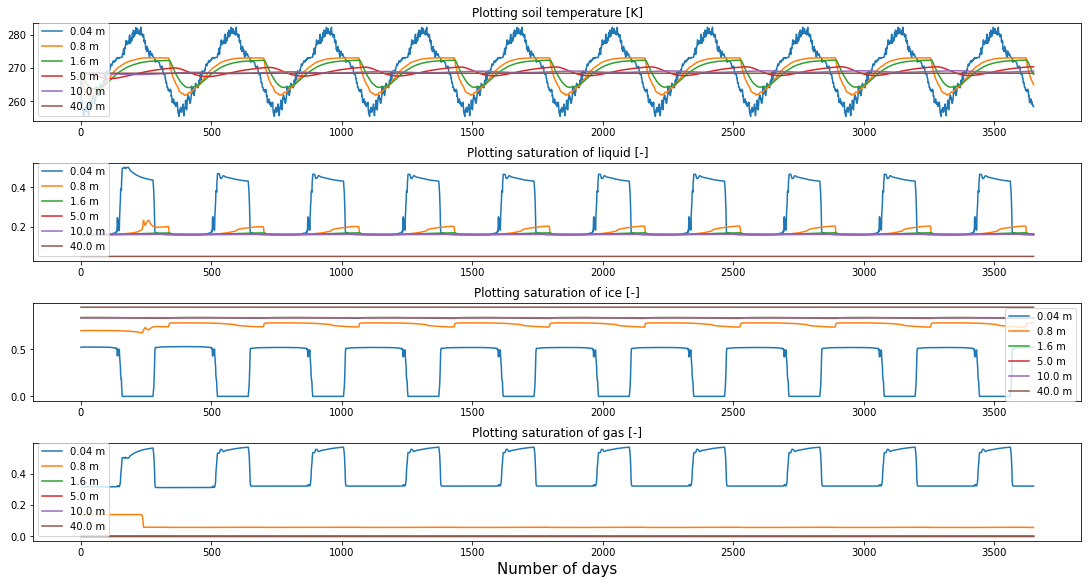

In [63]:
### Plotting the final results (mesured vs simulated) along with the parameters:
### Plotting the temperature for different alpha values at depth 0.01 m
fig2 = plt.figure(figsize=(15,8), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=4, height_ratios=[1,1,1,1], figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])
f2_ax4 = fig2.add_subplot(spec2[3, 0])

# Plotting temperature
f2_ax1.set_title('Plotting soil temperature [K]')
#plt.plot(df_observation['point -0.01 temperature [K]'][:1000],label='0.01 m')
f2_ax1.plot(df_observation['point -0.04 temperature [K]'],label='0.04 m')
#f2_ax1.plot(df_observation['point -0.04 temperature [K]'],'r--',label='0.04 m')
#f2_ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#f2_ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
f2_ax1.plot(df_observation['point -0.8 temperature [K]'],label='0.8 m')
#f2_ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
f2_ax1.plot(df_observation['point -1.6 temperature [K]'],label='1.6 m')
f2_ax1.plot(df_observation['point -5.0 temperature [K]'],label='5.0 m')
f2_ax1.plot(df_observation['point -10.0 temperature [K]'],label='10.0 m')
#f2_ax1.plot(df_observation['point -20.0 temperature [K]'],label='20.0 m')
f2_ax1.plot(df_observation['point -40.0 temperature [K]'],label='40.0 m')
f2_ax1.legend()

# Plotting saturation of liquid
f2_ax2.set_title('Plotting saturation of liquid [-]')
#plt.plot(df_observation['point -0.01 temperature [K]'][:1000],label='0.01 m')
f2_ax2.plot(df_observation['point -0.04 saturation liquid'],label='0.04 m')
#f2_ax2.plot(df_observation['point -0.2 saturation liquid'],label='0.2 m')
#f2_ax2.plot(df_observation['point -0.4 saturation liquid'],label='0.4 m')
f2_ax2.plot(df_observation['point -0.8 saturation liquid'],label='0.8 m')
#f2_ax2.plot(df_observation['point -1.2 saturation liquid'],label='1.2 m')
f2_ax2.plot(df_observation['point -1.6 saturation liquid'],label='1.6 m')
f2_ax2.plot(df_observation['point -5.0 saturation liquid'],label='5.0 m')
f2_ax2.plot(df_observation['point -10.0 saturation liquid'],label='10.0 m')
f2_ax2.plot(df_observation['point -40.0 saturation liquid'],label='40.0 m')
f2_ax2.legend()

# Plotting saturation of ice
f2_ax3.set_title('Plotting saturation of ice [-]')
#plt.plot(df_observation['point -0.01 temperature [K]'][:1000],label='0.01 m')
f2_ax3.plot(df_observation['point -0.04 saturation ice'],label='0.04 m')
#f2_ax3.plot(df_observation['point -0.2 saturation ice'],label='0.2 m')
#f2_ax3.plot(df_observation['point -0.4 saturation ice'],label='0.4 m')
f2_ax3.plot(df_observation['point -0.8 saturation ice'],label='0.8 m')
#f2_ax3.plot(df_observation['point -1.2 saturation ice'],label='1.2 m')
f2_ax3.plot(df_observation['point -1.6 saturation ice'],label='1.6 m')
f2_ax3.plot(df_observation['point -5.0 saturation ice'],label='5.0 m')
f2_ax3.plot(df_observation['point -10.0 saturation ice'],label='10.0 m')
#f2_ax3.plot(df_observation['point -20.0 saturation ice'],label='20.0 m')
f2_ax3.plot(df_observation['point -40.0 saturation ice'],label='40.0 m')
f2_ax3.legend()

# Plotting saturation of gas
f2_ax4.set_title('Plotting saturation of gas [-]')
#plt.plot(df_observation['point -0.01 temperature [K]'][:1000],label='0.01 m')
f2_ax4.plot(df_observation['point -0.04 saturation gas'],label='0.04 m')
#f2_ax4.plot(df_observation['point -0.2 saturation gas'],label='0.2 m')
#f2_ax4.plot(df_observation['point -0.4 saturation gas'],label='0.4 m')
f2_ax4.plot(df_observation['point -0.8 saturation gas'],label='0.8 m')
#f2_ax4.plot(df_observation['point -1.2 saturation gas'],label='1.2 m')
f2_ax4.plot(df_observation['point -1.6 saturation gas'],label='1.6 m')
#f2_ax4.plot(df_observation['point -1.6 saturation gas'],label='1.6 m')
f2_ax4.plot(df_observation['point -5.0 saturation gas'],label='5.0 m')
f2_ax4.plot(df_observation['point -10.0 saturation gas'],label='10.0 m')
f2_ax4.plot(df_observation['point -40.0 saturation gas'],label='40.0 m')
f2_ax4.set_xlabel('Number of days',fontsize=15)
f2_ax4.legend()

Comments: Observe that the saturation of gas reduces and saturation of ice increases at depth 0.8 m

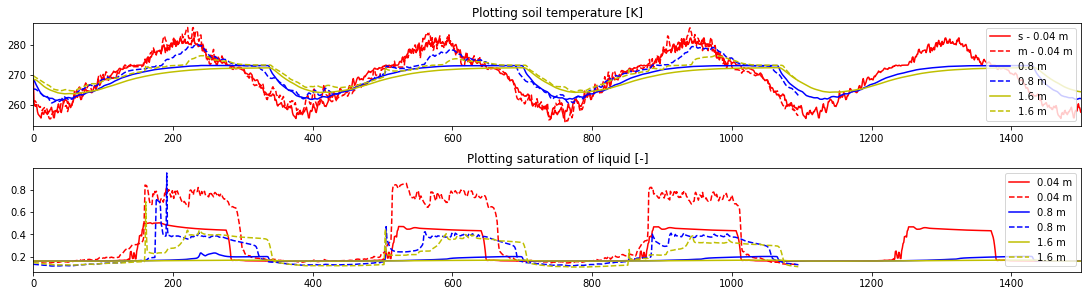

In [64]:
### Plotting the final results (mesured vs simulated) along with the parameters:
### Plotting the temperature for different alpha values at depth 0.01 m
fig2 = plt.figure(figsize=(15,4), constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1,1], figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])


# Plotting temperature
f2_ax1.set_title('Plotting soil temperature [K]')
#plt.plot(df_observation['point -0.01 temperature [K]'][:1000],label='0.01 m')
f2_ax1.plot(df_observation['point -0.04 temperature [K]'],'r',label='s - 0.04 m')
f2_ax1.plot(df_obs_AWS['point -0.04 temperature [K]'].values,'r--',label='m - 0.04 m')

#f2_ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#f2_ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
f2_ax1.plot(df_observation['point -0.8 temperature [K]'],'b',label='0.8 m')
f2_ax1.plot(df_obs_AWS['point -0.8 temperature [K]'].values,'b--',label='0.8 m')
#f2_ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
f2_ax1.plot(df_observation['point -1.6 temperature [K]'],'y',label='1.6 m')
f2_ax1.plot(df_obs_AWS['point -1.6 temperature [K]'].values,'y--',label='1.6 m')
f2_ax1.set_xlim(0,1500)
f2_ax1.legend()

# Plotting saturation of liquid
f2_ax2.set_title('Plotting saturation of liquid [-]')
#plt.plot(df_observation['point -0.01 temperature [K]'][:1000],label='0.01 m')
f2_ax2.plot(df_observation['point -0.04 saturation liquid'],'r',label='0.04 m')
f2_ax2.plot(df_obs_AWS['point -0.04 saturation liquid'].values,'r--',label='0.04 m')

#f2_ax1.plot(df_observation['point -0.2 temperature [K]'],label='0.2 m')
#f2_ax1.plot(df_observation['point -0.4 temperature [K]'],label='0.4 m')
f2_ax2.plot(df_observation['point -0.8 saturation liquid'],'b',label='0.8 m')
f2_ax2.plot(df_obs_AWS['point -0.8 saturation liquid'].values,'b--',label='0.8 m')
#f2_ax1.plot(df_observation['point -1.2 temperature [K]'],label='1.2 m')
f2_ax2.plot(df_observation['point -1.6 saturation liquid'],'y',label='1.6 m')
f2_ax2.plot(df_obs_AWS['point -1.6 saturation liquid'].values,'y--',label='1.6 m')
f2_ax2.set_xlim(0,1500)
f2_ax2.legend()

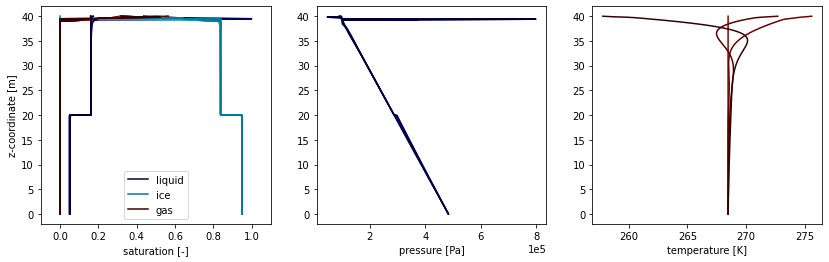

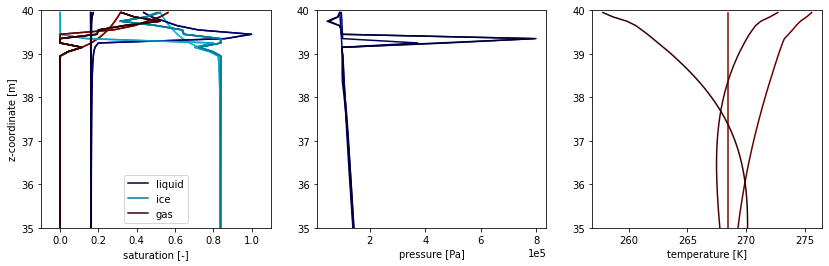

In [65]:
# plot the solution
directory = "Case1_dynamic_spinup.demo"

#
# plot the solution
#
def plot(dirname, axs):
    """A generic plotting function that plots saturation as a function of depth."""

    plot_column_data.plot_subsurface(vis, ['pressure',], axs[0], cmap='jet')
    axs[0].set_xlabel('pressure [Pa]')
    ax.set_ylabel('z [m]')
    
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[1], None, cmap='jet')
    axs[0].set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

def plot(directory, axs, style):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times
    
    ice = colors.cm_mapper(-10000, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10000, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10000, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = vis.centroids[:,2]
    for i,t in enumerate(times):
        label = False
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
        axs[2].plot(dati[5,i,:],z, style, color=gas(t))
        axs[1].plot(dati[1,i,:],z, style, color=water(t))
        axs[0].plot(dati[2,i,:],z, style, color=water(t))
        axs[0].plot(dati[3,i,:],z, style, color=ice(t))
        axs[0].plot(dati[4,i,:],z, style, color=gas(t))

def decorate(axs):
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[1].set_xlabel('pressure [Pa]')
    axs[2].set_xlabel('temperature [K]')
    axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs[0].set_xlim([-.1,1.1])
    axs[0].legend()


# full column
fig, axs = plt.subplots(1,3, figsize=(14,4))
plot(directory, axs, '-')
decorate(axs)

# and a zoomed version
fig, axs = plt.subplots(1,3, figsize=(14,4))
plot(directory, axs, '-')
decorate(axs)
axs[0].set_ylim([35,40])
axs[1].set_ylim([35,40])
axs[2].set_ylim([35,40])


plt.show()